Start by copying this into your Google Drive!!

# Information Retrieval & Text Mining
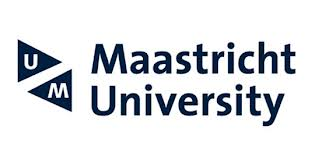
## Notebook 2

Version 2024-2025

Adapted and updated from [here](https://github.com/castorini/anserini-notebooks-afirm2020)

# Indexing

In this activity, we are going to index the [MS MARCO](http://www.msmarco.org/) passage collection and explore some features of the index.

## Setup

We are going to use the open-source [Anserini](https://github.com/castorini/anserini) information retrieval toolkit to run the experiments.
Anserini provides an easy-to-use interface over the popular [Apache Lucene](https://lucene.apache.org/) search library to facilitate rapid experimentation.

Here we clone the repository from GitHub but won't be dealing with other facets of Git. If you want to dive deeper into Git, here are some good resources:

- [Visual Git](http://marklodato.github.io/visual-git-guide/index-en.html)
- [Think Like (a) Git](http://think-like-a-git.net/)
- [Git from the bottom up](http://ftp.newartisans.com/pub/git.from.bottom.up.pdf)

In [ ]:
!git clone https://github.com/castorini/anserini.git
!cd anserini && git checkout ad5ba1c76196436f8a0e28efdb69960d4873efe3

Set up Java 11:

In [ ]:
!apt-get install -y openjdk-11-jdk-headless
%env JAVA_HOME=/usr/lib/jvm/java-11-openjdk-amd64

After cloning the Anserini repo, we should build it using Maven.

In [ ]:
# Install Maven
!apt-get install -q maven

Now is the time to build the `trec_eval` tool (more on this later):

In [ ]:
!cd anserini/eval && tar xvfz trec_eval.9.0.4.tar.gz && cd trec_eval.9.0.4 && make

Now lets build anserini. Please note that Maven has rather verbose logging, but so you only output the final lines that indicate whether or not the build succeeded.

In [ ]:
# Build Anserini
!cd anserini && mvn clean package appassembler:assemble | grep "BUILD"

## Data Preparation

MS MARCO (MicroSoft MAchine Reading COmprehension) is a large-scale dataset that defines many tasks from question answering to ranking.
Here we focus on the collection designed for passage re-ranking.

This collection is composed of the top 1000 most relevant passages for each query, as retrieved by BM25.

First, create a directory named `data/msmarco_passage` to hold the collection. Next, download the MS MARCO passage collection from the official MS MARCO mirror and extract the dataset.

In [ ]:
!mkdir -p data/msmarco_passage
!wget https://msmarco.z22.web.core.windows.net/msmarcoranking/collectionandqueries.tar.gz
!tar -xvf collectionandqueries.tar.gz -C data/msmarco_passage

Let's start exploring the passages in the collection:

In [ ]:
file="data/msmarco_passage/collection.tsv"
!wc -l $file
!head -5 $file

`collection.tsv` contains 8841823 passages, each labeled with a unique passage ID.

### Exercise #1
Find how many passages contain the phrase "South Africa" using `grep`, `wc` and the pipe operator `|`.
Also output the first 10 passages.

Now let's look at the development queries.
We will be using `queries/qrels.dev.small.tsv` for demonstration purposes, which constitutes a smaller subset of the queries (6,980 queries compared to the 101,093 queries of the original).

In [ ]:
!wc -l data/msmarco_passage/queries.dev.small.tsv

### Exercise #2
Output the top 3 queries that contain the term "football" and count the total number of words in them.

The final important component of the collection is the qrels files:

In [ ]:
!head -5 data/msmarco_passage/qrels.dev.small.tsv

### Exercise #3
Get the query ID of the query `average pay for nfl football players (39908)` from the previous exercise and see how many passages it is associated with.

### Exercise #4
Check the first passage that the query is associated with from the `collection.tsv` file.
Does it make sense?

As you can see, the original MS MARCO collection is a tab-separated values (TSV) file.
We need to convert the collection into the jsonl format that can be processed by Anserini.
jsonl files contain JSON object per line.

In [ ]:
!cd anserini && python ./src/main/python/msmarco/convert_collection_to_jsonl.py \
 --collection_path ../data/msmarco_passage/collection.tsv --output_folder ../data/msmarco_passage/collection_jsonl

The above command should generate 9 jsonl files in our `data/msmarco_passage/collection_jsonl` directory, each with 1M lines (except for the last one, which should have 841,823 lines).

In [ ]:
!wc -l data/msmarco_passage/collection_jsonl/*

jsonl files are JSON files with keys `id` and `contents`:

In [ ]:
!head -5 data/msmarco_passage/collection_jsonl/docs00.json

Let's remove the original files to make room for the index.
Check the contents of `data/msmarco_passage` before and after.
Alternatively, you can look at your filesystem in the menu on the left by clicking the bottom icon.

In [ ]:
!ls data/msmarco_passage
!rm data/msmarco_passage/*.tsv
!ls data/msmarco_passage
!rm -rf sample_data

## Indexing

Some common indexing options with Anserini:

- `input`: Path to collection
- `threads`: Number of threads to run
- `collection`: Type of Anserini Collection, e.g., LuceneDocumentGenerator, TweetGenerator (subclass of LuceneDocumentGenerator for TREC Microblog)
- `index`: Path to index output
- `storePositions`: Boolean flag to store positions
- `storeDocvectors`: Boolean flag to store document vbectors
- `storeRawDocs`: Boolean flag to store raw document text
- `keepStopwords`: Boolean flag to keep stopwords (False by default)
- `stemmer`: Stemmer to use ([Porter](http://snowball.tartarus.org/algorithms/porter/stemmer.html) by default)

We now have everything in place to index the collection.
The process takes about 10 minutes; in the meantime, you can already work on the next colab or take a break.

In [ ]:
!cd anserini && sh target/appassembler/bin/IndexCollection -collection JsonCollection -input ../data/msmarco_passage/collection_jsonl \
 -index ../indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs -generator DefaultLuceneDocumentGenerator -threads 9 \
 -storePositions -storeDocvectors -storeRaw

Check the size of the index at the specified destination:

In [ ]:
!du -h indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs

## Explore the Index

We can explore the index with [Pyserini](https://github.com/castorini/pyserini), the Python interface to Anserini.

### Setup

Install Python dependencies:

In [ ]:
!pip install pyjnius==1.2.1
!pip install pyserini==0.9.2.0

import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

Fix known issue with pyjnius (see [this explanation](https://github.com/castorini/pyserini/blob/master/README.md#known-issues) for details):

In [ ]:
!mkdir -p /usr/lib/jvm/java-1.11.0-openjdk-amd64/jre/lib/amd64/server/
!ln -s /usr/lib/jvm/java-1.11.0-openjdk-amd64/lib/server/libjvm.so /usr/lib/jvm/java-1.11.0-openjdk-amd64/jre/lib/amd64/server/libjvm.so

Let's point Pyserini to the Anserini jar that we built earlier:

In [ ]:
os.environ['ANSERINI_CLASSPATH'] = 'anserini/target'

In [ ]:
from pyserini.index import pyutils

index_utils = pyutils.IndexReaderUtils('indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs')

Collection frequency corresponds to the total number of times a term appears in the index.
Document frequency, as the name implies, refers to the number of documents that contains the term.

For example, consider a toy index that looks like:

```
Document 1: "here is some text here is some more text"
Document 2: "more texts"
Document 3: "here is a test"
```

The collection frequency of the term `text` is 3 (2 times in Document 1 and once in Document 2).
However, its document frequency is 2.
Intuitively, document frequency is always equal to or less than collection frequency.

Let's choose a term, say, `played`.
We can now compute the collection and document frequencies of the term:

In [ ]:
term = 'played'

stemmed_form = index_utils.analyze(term)
collection_freq, doc_freq = index_utils.get_term_counts(term)

print('Stemmed form: {stemmed_form}\nCollection frequency: {collection_freq}\nDocument frequency: {doc_freq}'.format(stemmed_form=stemmed_form, collection_freq=collection_freq, doc_freq=doc_freq))

### Exercise #5
Get the same statistics for the term `playing`.
Compare the collection and document frequencies to that of the term `played`.
Why are they different/the same?

In simple terms, we can think of the index as a dictionary of terms each of which is a postings list.
A postings list includes a list of document IDs that contains a given term, and optionally the number of occurrences in that particular document.
Because we also stored the positions while indexing the collection, we can also access the positions at which the term appears.

Let's get the postings list for the term `rondebosch`:

In [ ]:
postings_list = index_utils.get_postings_list('rondebosch')

for posting in postings_list:
  print('Document ID: {docid} | Term frequency: {term_freq} | Positions: {pos}'.format(docid=posting.docid, term_freq=posting.tf, pos=','.join([str(p) for p in posting.positions])))

### Exercise #6
Note that tokens are stemmed prior to indexing.
For example, both `played` and `playing` would share the same postings list.
Confirm this by building the postings list for `playing`.

Let's get its document vector of two documents:

In [ ]:
doc_vector1 = index_utils.get_document_vector('2803')
doc_vector2 = index_utils.get_document_vector('3983')

print(doc_vector1)
print(doc_vector2)

Let's view the original passages:

In [ ]:
raw_doc1 = index_utils.doc_raw('2803')
raw_doc2 = index_utils.doc_raw('3983')

print(raw_doc1)
print(raw_doc2)

The document vector gives a succinct representation of the overall document.
We can use the respective representations of two documents to judge their similarity.

In [ ]:
import math

def dot_prod(doc1, doc2):
  tokens1 = set(doc1.keys())
  tokens2 = set(doc2.keys())
  all_tokens = list(tokens1 & tokens2)  # Get common tokens (otherwise different sized dicts)
  return sum(doc1[t] * doc2[t] for t in all_tokens)

def cosine_similarity(doc1, doc2):
  return dot_prod(doc1, doc2) / (math.sqrt(dot_prod(doc1, doc1)) * dot_prod(doc2, doc2))

cosine_similarity(doc_vector1, doc_vector2)

### Exercise #7
Pick different pairs of documents, and compute the cosine similarity between them.